In [2]:
import pandas as pd
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import Data
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# 读取dataframe并且处理一下

# 注：数据处理时，训练集和测试集放在一起处理

In [3]:
id_and_date_columns = ["geohash_id", "date_id"]
label_columns = ["active_index", "consume_index"]

读节点

In [4]:
# 读取训练集node
node_df_train = pd.read_csv("data/raw/train_90.csv")
node_ids = node_df_train["geohash_id"].unique().tolist()

In [5]:
node_ids.index("5324516fr")

1

In [6]:
# 读取测试集node
node_df_test = pd.read_csv("data/raw/A榜/node_test_4_A.csv")
# 测试集中有一些不正确的node_id，需要进行转化
special_node = {
    "18377236": "018377236",
    "7.45E+07": "7449766e1",
    "9.80E+10": "9797336e4",
}
node_df_test.replace(special_node, inplace=True)
# 现在测试集中的node_id都是正确的
assert node_df_test["geohash_id"].isin(node_ids).value_counts().item() == len(
    node_df_test
)

### 合并两个df进行特征工程

In [7]:
node_df_all = pd.concat([node_df_train, node_df_test], axis=0)
node_df_all

,geohash_id,date_id,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,...,F_28,F_29,F_30,F_31,F_32,F_33,F_34,F_35,active_index,consume_index
0,4885e281g,20230104,-0.711,-0.696,-0.794,-0.727,-0.747,-0.792,1.539,2.433,...,0.073,0.344,0.006,-0.446,-0.502,-0.456,-0.457,-0.830,69.306,63.78
1,4885e281g,20230105,-0.909,-0.903,-0.947,-0.844,-0.856,-0.908,-0.371,0.990,...,0.055,0.298,0.007,-0.523,-0.558,-0.533,0.113,-0.887,68.881,61.62
2,4885e281g,20230106,-0.920,-0.925,-0.923,-0.852,-0.853,-0.915,-0.334,0.792,...,0.067,0.324,0.006,-0.535,-0.564,-0.540,0.367,-1.021,69.738,61.03
3,4885e281g,20230107,-0.926,-0.931,-0.943,-0.837,-0.850,-0.907,-0.993,-0.006,...,0.076,0.276,0.010,-0.534,-0.554,-0.521,0.550,-0.211,68.721,62.02
4,4885e281g,20230108,-0.750,-0.764,-0.818,-0.749,-0.764,-0.816,1.116,1.447,...,0.079,0.328,0.008,-0.468,-0.500,-0.419,-0.236,0.644,69.960,64.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4555,607779c2c,20230407,0.566,0.626,0.430,0.436,0.681,0.668,0.921,0.919,...,0.076,0.323,0.021,1.002,0.446,0.796,-1.275,0.291,NaN,NaN
4556,1d3640fad,20230404,1.158,0.893,1.497,1.847,1.862,1.597,-0.415,-1.551,...,0.067,0.283,0.057,1.824,1.526,1.528,-0.750,-0.458,NaN,NaN
4557,1d3640fad,20230405,2.245,1.940,2.759,3.137,3.241,2.626,-0.270,-1.296,...,0.070,0.316,0.015,3.086,2.543,2.564,-0.834,-1.029,NaN,NaN
4558,1d3640fad,20230406,2.154,1.912,2.978,3.158,3.194,2.614,-0.438,-1.337,...,0.073,0.315,0.023,3.005,2.534,2.576,-0.770,-0.709,NaN,NaN


/home/liqiang/software/miniconda3/envs/pyg/lib/python3.10/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


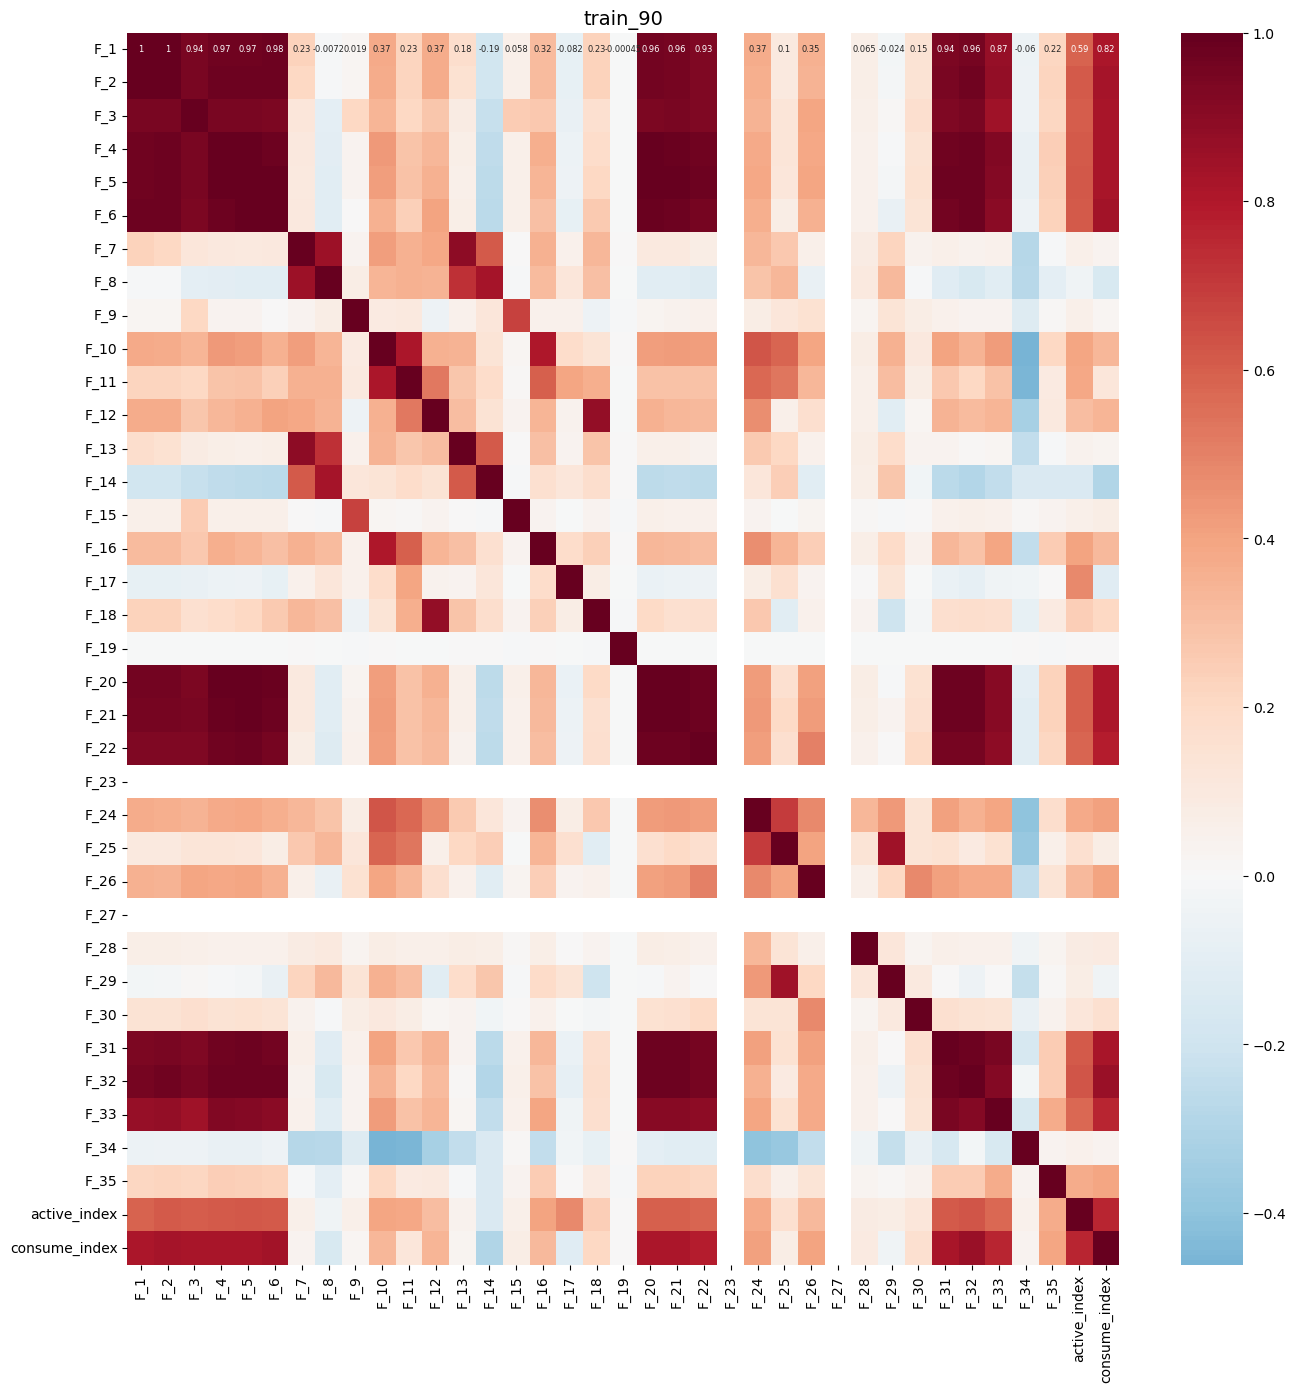

In [8]:
# 绘制热力图，查看特征之间的相关性
def make_corr(df, cols, Vtitle=""):
    plt.figure(figsize=(16, 16))
    sns.heatmap(
        df[cols].corr(), cmap="RdBu_r", annot=True, center=0.0, annot_kws={"size": 6}
    )
    plt.title(Vtitle, fontsize=14)
    plt.show()


make_corr(node_df_all, node_df_all.columns[2:], "train_90")

In [9]:
# 先对特征进行标准化
scaler = StandardScaler()
node_df_all.iloc[:, 2:-2] = scaler.fit_transform(node_df_all.iloc[:, 2:-2])
node_df_all.describe()

,date_id,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,...,F_28,F_29,F_30,F_31,F_32,F_33,F_34,F_35,active_index,consume_index
count,1.071600e+05,1.071600e+05,1.071600e+05,1.071600e+05,1.071600e+05,1.071600e+05,1.071600e+05,1.071600e+05,1.071600e+05,1.071600e+05,...,1.071600e+05,1.071600e+05,1.071600e+05,1.071600e+05,1.071600e+05,1.071600e+05,1.071600e+05,1.071600e+05,102600.000000,102600.000000
mean,2.023023e+07,2.440087e-17,6.471535e-17,1.273089e-17,5.304537e-18,-8.487259e-18,2.970541e-17,-1.644406e-17,1.989201e-17,-1.060907e-17,...,6.033911e-17,1.268845e-15,-3.548735e-16,9.548167e-18,2.440087e-17,4.774083e-17,2.121815e-18,-2.917495e-17,70.247293,69.805251
std,9.268582e+01,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,...,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,3.433761,8.681361
min,2.023010e+07,-1.117142e+00,-1.169135e+00,-1.148762e+00,-1.047973e+00,-1.070092e+00,-1.096630e+00,-5.489250e+00,-5.040815e+00,-3.037168e+00,...,-2.262530e+00,-5.746634e+00,-1.511144e+00,-1.067975e+00,-1.182107e+00,-9.286553e-01,-3.512946e+00,-2.864842e+00,42.143000,28.300000
25%,2.023013e+07,-7.207491e-01,-7.300221e-01,-7.191253e-01,-6.901002e-01,-6.959612e-01,-7.233696e-01,-8.008577e-01,-6.512290e-01,-5.019074e-01,...,-3.601964e-01,-5.880492e-01,-3.618457e-01,-7.057331e-01,-7.478771e-01,-6.427467e-01,-6.702064e-01,-5.292359e-01,68.564000,64.680000
50%,2.023022e+07,-2.532854e-01,-2.337647e-01,-2.439981e-01,-2.578375e-01,-2.584690e-01,-2.550429e-01,2.079604e-01,-2.342903e-02,-1.053975e-01,...,-1.818526e-01,-1.378455e-01,-1.319860e-01,-2.644568e-01,-2.233856e-01,-2.593040e-01,-3.616723e-02,-3.815981e-02,70.475000,70.900000
75%,2.023032e+07,4.073699e-01,4.291652e-01,4.242127e-01,3.624091e-01,3.781575e-01,4.094206e-01,6.882543e-01,5.612473e-01,3.652077e-01,...,8.566303e-02,4.624262e-01,2.128037e-01,3.776989e-01,4.633323e-01,3.077322e-01,6.321179e-01,4.479257e-01,72.175000,75.670000
max,2.023041e+07,1.002491e+01,1.016659e+01,1.463658e+01,1.324886e+01,1.175798e+01,1.037737e+01,6.158380e+00,1.031020e+01,5.702307e+01,...,2.746143e+01,1.301186e+01,1.134187e+02,1.346670e+01,1.014935e+01,3.852004e+01,6.274218e+00,3.657196e+01,99.797000,100.000000


In [19]:
# 再进行主成分分析
# 使用PCA方法进行降维
from sklearn.decomposition import PCA

pca = PCA(n_components=0.999)
cns = node_df_all.columns[2:-2]
new_features = pca.fit_transform(node_df_all[cns])

In [20]:
new_features.shape

(107160, 27)

In [22]:
node_df_all.iloc[:, 2 : 2 + new_features.shape[1]] = new_features

In [28]:
# 删除多余的特征
node_df_all.drop(node_df_all.columns[2 + new_features.shape[1] : -2], axis=1, inplace=True)

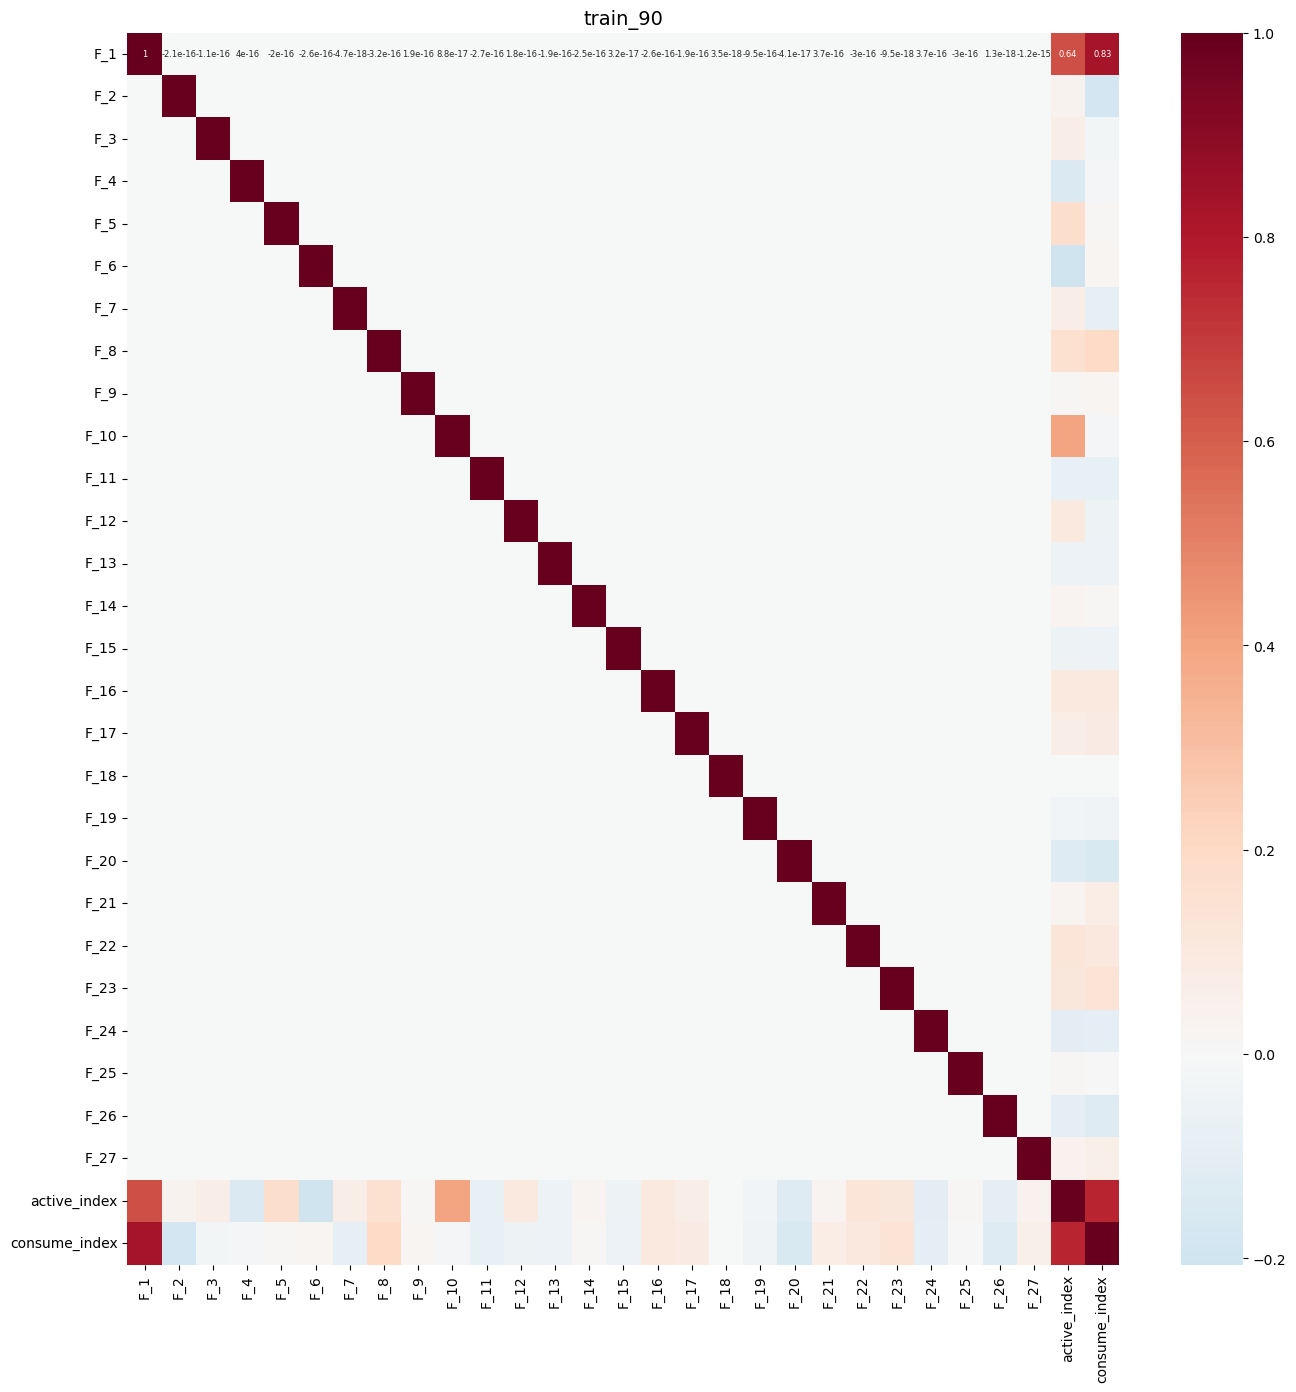

In [29]:
# 绘制热力图，查看特征之间的相关性
make_corr(node_df_all, node_df_all.columns[2:], "train_90")

### 搞定，重新分成训练集和测试集

In [45]:
# 重新划分训练集和测试集
node_df_train = node_df_all.iloc[: len(node_df_train)]
node_df_test = node_df_all.iloc[len(node_df_train) :, :-2]

In [46]:
node_df_train

,geohash_id,date_id,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,...,F_20,F_21,F_22,F_23,F_24,F_25,F_26,F_27,active_index,consume_index
0,4885e281g,20230104,-1.998777,5.019110,-1.308464,0.630424,-0.927729,-1.178872,0.061651,-0.753680,...,-0.167076,0.398012,-0.164486,0.056571,-0.220923,0.035218,0.080396,-0.046755,69.306,63.78
1,4885e281g,20230105,-3.190947,1.408002,0.015554,-0.435858,-0.715444,-1.123590,0.336542,-1.028369,...,0.183207,0.426226,-0.103659,0.203715,-0.117925,0.082871,0.103750,-0.116915,68.881,61.62
2,4885e281g,20230106,-3.085900,2.989448,-0.884125,0.756096,-1.461125,-1.607772,0.535984,-0.657179,...,-0.156374,0.614057,0.406814,-0.317317,-0.545054,0.548377,0.566537,-0.170542,69.738,61.03
3,4885e281g,20230107,-3.180187,0.201542,0.215664,-0.847032,-0.220122,-1.224798,0.007344,0.129478,...,0.089227,0.219049,0.089460,-0.035827,-0.281664,0.207316,0.288489,-0.180157,68.721,62.02
4,4885e281g,20230108,-2.091985,3.218017,-0.237171,-0.389651,-0.377389,-1.220743,-0.304482,0.553976,...,0.178481,0.207987,-0.144186,-0.054223,-0.053715,-0.098971,-0.093398,-0.037942,69.960,64.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102595,1d3640fad,20230330,10.393065,-1.452262,1.221682,-0.705173,0.745483,0.181613,0.554668,-0.661028,...,0.300303,-0.071159,-0.963877,-0.142039,-0.403659,-0.348663,-0.109645,0.174572,74.582,85.81
102596,1d3640fad,20230331,11.352295,-2.615838,2.896545,-0.594261,-0.111105,1.239002,0.553781,-1.852608,...,0.087558,-0.429912,-1.556374,-0.993747,-0.476882,-0.355999,-0.319826,-0.158644,73.194,86.31
102597,1d3640fad,20230401,3.304249,-2.717453,4.803657,-1.528352,1.206682,1.291794,-0.119524,-2.034286,...,0.064293,-0.034306,-0.271347,-0.400337,-0.275812,-0.108775,-0.250033,-0.024851,72.713,79.83
102598,1d3640fad,20230402,2.259845,-3.046846,4.340932,-1.389519,1.215404,0.618922,0.103210,-1.869729,...,0.042524,-0.105345,0.082653,-0.431949,-0.192697,-0.183600,-0.162451,0.112618,72.394,78.72


In [47]:
node_df_test

,geohash_id,date_id,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,...,F_18,F_19,F_20,F_21,F_22,F_23,F_24,F_25,F_26,F_27
0,4885e281g,20230404,-2.549415,3.128117,-0.800843,0.906513,0.732533,0.029518,0.769145,-1.636825,...,0.328011,0.119466,-0.353172,-0.079033,-0.105088,0.066722,0.147905,-0.117504,-0.137825,0.004154
1,4885e281g,20230405,-2.180115,2.743909,-0.208088,0.309399,0.717209,0.336736,0.439383,-1.262514,...,0.160957,-0.023565,-0.124777,0.005294,0.185586,0.015739,0.172113,-0.180848,-0.085233,0.003172
2,4885e281g,20230406,-2.140952,3.500403,-1.479871,0.379854,0.492856,0.295323,0.281892,-1.491410,...,0.352580,-0.000728,0.034096,0.039329,0.060992,0.148568,0.072904,-0.099195,-0.089302,-0.005678
3,4885e281g,20230407,-1.579711,3.968029,-0.553558,0.167996,0.344043,1.417651,1.126889,-0.467487,...,0.647234,0.127350,-0.118431,0.363615,0.221358,-0.160092,-0.210259,0.205321,0.138328,0.054162
4,5324516fr,20230404,-3.045060,1.377982,0.296779,-1.365420,0.580454,1.913546,-6.722568,-1.455419,...,0.282416,-0.122478,0.165576,-0.649070,-0.187551,0.395271,-0.049388,0.014760,0.287508,-0.026567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4555,607779c2c,20230407,3.717456,3.744338,-0.313592,-1.234380,1.663833,1.860115,0.501958,-0.404630,...,0.082185,0.032416,-0.220758,-0.325757,0.318649,-0.141939,-0.103939,0.114887,0.068518,-0.119106
4556,1d3640fad,20230404,7.023717,-0.565475,2.360829,-0.784758,1.183531,3.836123,2.387102,-0.111015,...,0.691905,-0.300322,0.095385,0.077330,-0.977437,-0.323306,-0.085631,-0.269644,-0.228372,-0.081980
4557,1d3640fad,20230405,10.840870,-0.802464,1.555715,-0.590747,0.131704,0.312545,0.505158,-2.480824,...,0.748185,-0.267666,0.107601,-0.345546,-1.010755,-0.393393,-0.372036,-0.318908,-0.259569,0.027088
4558,1d3640fad,20230406,10.861976,-0.817323,1.803728,-0.518022,0.587851,0.800065,0.756102,-1.656028,...,0.771802,-0.360987,0.121306,-0.377016,-0.927815,-0.295758,-0.526058,-0.385799,-0.118006,0.100278


## 边也是一样的处理方法，不过先不用pca了

In [37]:
edge_df_train = pd.read_csv("data/raw/edge_90.csv")
edge_df_test = pd.read_csv("data/raw/A榜/edge_test_4_A.csv")
len(edge_df_train), len(edge_df_test)

(1048575, 85604)

In [38]:
# 合并，进行标准化
edge_df_all = pd.concat([edge_df_train, edge_df_test], axis=0)
edge_df_all

,geohash6_point1,geohash6_point2,F_1,F_2,date_id
0,9b88bf98h,a23e95cet,3,7,20230114
1,6364ec2e6,da07e496h,7,43,20230312
2,3bc27f75d,7c88148f3,2,6,20230324
3,b5dbab8e1,63031200k,3,38,20230109
4,b21e7c81z,b1899e1ct,1,7,20230306
...,...,...,...,...,...
85599,39138745y,1e37f6184,4,25,20230405
85600,ef82b2118,dba81976r,1,18,20230405
85601,6c26e502e,73781635m,5,42,20230406
85602,b5ecebfbq,4b78be9e5,46,44,20230406


In [39]:
# 标准化
edge_feature_columns = ["F_1", "F_2"]
scaler = StandardScaler()
edge_df_all.loc[:, edge_feature_columns] = scaler.fit_transform(
    edge_df_all[edge_feature_columns]
)

In [42]:
edge_df_all.describe()

,F_1,F_2,date_id
count,1.134179e+06,1.134179e+06,1.134179e+06
mean,9.484938e-18,-1.133682e-16,2.023024e+07
std,1.000000e+00,1.000000e+00,9.648734e+01
min,-1.238596e-01,-1.697338e+00,2.023010e+07
25%,-1.220144e-01,-8.660528e-01,2.023013e+07
50%,-1.183241e-01,3.450652e-02,2.023022e+07
75%,-9.987223e-02,8.657920e-01,2.023032e+07
max,7.955120e+01,1.697078e+00,2.023041e+07


In [40]:
# 拆成训练集和测试集
edge_df_train = edge_df_all.iloc[: len(edge_df_train)]
edge_df_test = edge_df_all.iloc[len(edge_df_train) :]

In [41]:
len(edge_df_train), len(edge_df_test)

(1048575, 85604)

# 建图

In [48]:
feature_columns = node_df_train.columns[2:-2].tolist()
feature_columns

['F_1',
 'F_2',
 'F_3',
 'F_4',
 'F_5',
 'F_6',
 'F_7',
 'F_8',
 'F_9',
 'F_10',
 'F_11',
 'F_12',
 'F_13',
 'F_14',
 'F_15',
 'F_16',
 'F_17',
 'F_18',
 'F_19',
 'F_20',
 'F_21',
 'F_22',
 'F_23',
 'F_24',
 'F_25',
 'F_26',
 'F_27']

In [49]:
def buildGraph(node_df, edge_df, is_test_dataset=False):
    graphs = []

    # 按照date_id分组
    for date_id, graph in node_df.groupby("date_id"):
        # 节点
        x = torch.tensor(graph[feature_columns].values, dtype=torch.float)
        if not is_test_dataset:
            y = torch.tensor(graph[label_columns].values, dtype=torch.float)

        # 边
        edge_day_df = edge_df[edge_df["date_id"] == date_id]
        edge_index, edge_attr = [], []
        for _, edge in edge_day_df.iterrows():
            # 边可能给多了，只取存在的
            if (
                edge["geohash6_point1"] not in node_ids
                or edge["geohash6_point2"] not in node_ids
            ):
                continue
            edge_index.append(
                [
                    node_ids.index(edge["geohash6_point1"]),
                    node_ids.index(edge["geohash6_point2"]),
                ]
            )
            edge_attr.append(edge[edge_feature_columns].values.astype(np.float32))
        edge_index = (
            torch.tensor(np.array(edge_index), dtype=torch.long).t().contiguous()
        )
        edge_attr = torch.tensor(np.array(edge_attr), dtype=torch.float)

        # 图
        if is_test_dataset:
            graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        else:
            graph = Data(x=x, y=y, edge_index=edge_index, edge_attr=edge_attr)
        graphs.append(graph)

        print(date_id, "finished")

    return graphs

In [50]:
graphs = buildGraph(node_df_train, edge_df_train)

20230104 finished
20230105 finished
20230106 finished
20230107 finished
20230108 finished
20230109 finished
20230110 finished
20230111 finished
20230112 finished
20230113 finished
20230114 finished
20230115 finished
20230116 finished
20230117 finished
20230118 finished
20230119 finished
20230120 finished
20230121 finished
20230122 finished
20230123 finished
20230124 finished
20230125 finished
20230126 finished
20230127 finished
20230128 finished
20230129 finished
20230130 finished
20230131 finished
20230201 finished
20230202 finished
20230203 finished
20230204 finished
20230205 finished
20230206 finished
20230207 finished
20230208 finished
20230209 finished
20230210 finished
20230211 finished
20230212 finished
20230213 finished
20230214 finished
20230215 finished
20230216 finished
20230217 finished
20230218 finished
20230219 finished
20230220 finished
20230221 finished
20230222 finished
20230223 finished
20230224 finished
20230225 finished
20230226 finished
20230227 finished
20230228 f

In [51]:
def saveData(data, path):
    with open(path, "wb") as file:
        pickle.dump(data, file)
        file.close()


saveData(graphs, "data/feature_engineering/train_graphs_data.pkl")

In [52]:
# 保存node_id和index的对应关系
saveData(node_ids, "data/feature_engineering/node_ids.pkl")

# 生成训练集图

In [53]:
test_graphs = buildGraph(node_df_test, edge_df_test, is_test_dataset=True)

20230404 finished
20230405 finished
20230406 finished
20230407 finished


In [54]:
saveData(test_graphs, "data/feature_engineering/test_graphs_data.pkl")